# RAGAS Basic
1. 지식그래프 분석
   * MultiHopSpecific Type에 사용되는 OverlapScoreBuilder Relation의 문제 발견
   * OverlapScoreBuilder는 Named Entity(사람, 조직, 장소 등 고유한 이름) 추출을 기반으로 관계를 형성
   * Named Entity의 섹션 간 분포가 불균형한 것으로 분석됨
     - Named Entity별 타 섹션 분포 분석 결과, 대부분의 Entity가 동일 섹션 내에 집중되어 있는 것으로 확인됨
     - 이는 문서의 구조적 특성과 Named Entity의 분포 특성에 기인하는 것으로 파악됨
   * 이로 인해 OverlapScoreBuilder 기반 관계의 수가 매우 제한적이며, 섹션 간 network density가 낮은 것으로 파악됨
   * MultiHopSpecificQuery Type의 문제점 분석
      * 질의 생성이 동일 섹션 결합에 과도하게 의존하는 것으로 확인됨
      * 이는 다양한 섹션 간의 관계를 활용한 질의 생성이 제한되는 결과로 이어짐
2. MultiHopAbstractQuerySynthesizer 최적화 필요
   * 기존: 매번 관계를 순회하며 이웃노드 검색
   * 개선방안: 이웃 노드 맵을 통해 한 번의 순회로 모든 관계 처리
3. 생성 페르소나와 실제 사용자 간의 불일치 발생
   * 생성 페르소나는 문서 요약을 기반으로 생성됨
   * 요약을 기반으로 해당 요약 콘텐츠와 상호작용하거나 혜택을 받을 가능성이 있는 단일 페르소나를 생성함
   * 이로 인해 문서 독자와 RAG 예상 사용자 간의 특성 차이가 발생하는 것으로 파악됨
   * 이는 생성된 페르소나가 실제 사용자 그룹을 충분히 대표하지 못하는 결과로 이어짐

In [4]:
import os
import json
from tqdm import tqdm

from dotenv import load_dotenv
load_dotenv()

True

In [5]:
with open('../data/document/역도/chunk_with_overlap.json', 'r', encoding='utf-8') as f:
    origin_data = json.load(f)


total_data = []
for data in origin_data:
    total_data.extend(data)

print(len(total_data))

255


## 1. 지식 그래프 생성

In [6]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from ragas.testset.graph import KnowledgeGraph
from ragas.testset.graph import Node, NodeType

generator_llm = LangchainLLMWrapper(ChatOpenAI(model='gpt-4o-mini'))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

c:\Users\owner\anaconda3\envs\SportAgent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from langchain_core.documents import Document

kg = KnowledgeGraph()

for doc in total_data:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={'page_content': doc['page_content'],
                        'document_metadata': doc['metadata']}
        )
    )

In [8]:
from ragas.testset.transforms import apply_transforms
from ragas.testset.transforms.extractors.embeddings import EmbeddingExtractor
from ragas.testset.transforms.extractors.llm_based import (
    SummaryExtractor,
    ThemesExtractor,
    NERExtractor
)
ner_extractor = NERExtractor(llm=generator_llm)
summary_extractor = SummaryExtractor(llm=generator_llm)
themes_extractor = ThemesExtractor(llm=generator_llm)
embedding_extractor = EmbeddingExtractor(
    embedding_model=generator_embeddings,
    property_name="summary_embedding",
    embed_property_name="summary",
    filter_nodes=lambda node: node.get_property("summary") is not None
)

transforms = [
    ner_extractor,
    summary_extractor,
    themes_extractor,
    embedding_extractor
]

# apply_transforms(kg, transforms)

In [9]:
from ragas.testset.transforms.relationship_builders import (
    CosineSimilarityBuilder,
    OverlapScoreBuilder,
)

cosine_sim_builder = CosineSimilarityBuilder(
    property_name="summary_embedding",
    new_property_name="summary_similarity",
    threshold=0.7
)

relation_builder = OverlapScoreBuilder(
    property_name="entities",
    new_property_name="overlap_score",
    threshold=0.01,
    distance_threshold=0.9,
)

transforms = [cosine_sim_builder, relation_builder]
# apply_transforms(kg, transforms)

In [10]:
# kg.save('../data/document/역도/kg.json')
kg = KnowledgeGraph.load('../data/document/역도/kg.json')

## 2. knowledge graph 분석 

### 2-1. knowledge graph의 nodes 분석
* 분석항목
  * 전체 문서 내 최빈 entity
  * 각 단원(sector)별 최빈 entity
  * 각 단원별 비검출 node 수
* 현황 분석
  * NERExtractor 특징
    * NERExtractor는 일반 entity가 아닌 named entity를 추출함
    * named entity는 고유명사로 특정 이름을 가진 개체로, 주로 사람, 장소, 조직, 날짜/시간 등을 대상으로 함
  * 시사점
    * 최빈 상위 10개 entity 분석 결과, '바벨', '역도', '무릎', '역도선수', '심리기술훈련' 등 사용자 예상 질문과 관련성이 적은 entity가 주로 추출
    * 섹터별 상위 entity 분포 결과, 문서 전체에 분포하는 entity가 부재

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def analyze_node_entity(kg, entity_name=None):
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.rcParams['axes.unicode_minus'] = False

    # 데이터 구조 초기화
    sector_null = {}
    sector_total = {}
    sector_entities = {}
    total_entities = []
    sectors_order = []
    total_node_count = len(kg.nodes)
    null_node_count = 0

    # 데이터 수집
    for node in kg.nodes:
        sector = node.properties['document_metadata']['heading']['heading1']
        if entity_name != None:
            entities = node.properties['exercise_entities'].get(entity_name, [])
        else:
            entities = node.properties.get('entities', [])
        if sector not in sectors_order:
            sectors_order.append(sector)
        if sector not in sector_null:
            sector_null[sector] = 0
            sector_total[sector] = 0
            sector_entities[sector] = []
        sector_total[sector] += 1
        if not entities:
            sector_null[sector] += 1
            null_node_count += 1
        else:
            sector_entities[sector].extend(entities)
            total_entities.extend(entities)

    # 전체 entity 없는 노드 비율 계산
    null_ratio = null_node_count / total_node_count * 100

    # 섹터별 entity 없는 노드 비율 계산
    sector_null_ratio = {sector: sector_null[sector] / sector_total[sector] * 100 for sector in sectors_order}

    # 전체 상위 10개 entity
    total_entity_counts = Counter(total_entities)
    top_total_entities = dict(sorted(total_entity_counts.items(), key=lambda x: x[1], reverse=True)[:10])

    # 섹터별 상위 5개 entity
    sector_top_entities = {}
    for sector in sectors_order:
        counts = Counter(sector_entities[sector])
        sector_top_entities[sector] = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5])

    # 시각화
    plt.figure(figsize=(15, 10))

    # 1. 섹터별 entity 없는 노드 비율 막대그래프
    plt.subplot(2, 2, 1)
    bars1 = plt.bar(sector_null_ratio.keys(), sector_null_ratio.values(), color='skyblue')
    plt.ylabel('비율(%)')
    plt.title(f'섹터별 Entity 없는 노드 비율\n(전체 노드 중 entity 없는 노드 비율: {null_ratio:.1f}%)')
    plt.xticks(rotation=45, ha='right')
    # 막대 위에 값 표시
    for bar in bars1:
        height = bar.get_height()
        plt.annotate(f'{height:.1f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3pt 위에
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 2. 전체 상위 10개 entity 막대 그래프
    plt.subplot(2, 2, 2)
    bars2 = plt.bar(top_total_entities.keys(), top_total_entities.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('전체 상위 10개 Entity')
    # 막대 위에 값 표시
    for bar in bars2:
        height = bar.get_height()
        plt.annotate(f'{int(height)}', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

    # 3. 섹터별 상위 entity 히트맵 (깔끔하게)
    plt.subplot(2, 1, 2)
    sectors = list(sector_top_entities.keys())
    all_entities = sorted({e for ents in sector_top_entities.values() for e in ents})
    heatmap_data = np.zeros((len(sectors), len(all_entities)))
    for i, sector in enumerate(sectors):
        for j, entity in enumerate(all_entities):
            heatmap_data[i, j] = sector_top_entities[sector].get(entity, 0)

    im = plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd')

    # 컬러바
    cbar = plt.colorbar(im, label='출현 빈도')
    cbar.ax.tick_params(labelsize=10)

    # x, y축 라벨
    plt.xticks(range(len(all_entities)), all_entities, rotation=45, ha='right', fontsize=10)
    plt.yticks(range(len(sectors)), sectors, fontsize=10)
    plt.xlabel('Entity', fontsize=12)
    plt.ylabel('Sector', fontsize=12)
    plt.title('섹터별 상위 Entity 분포', fontsize=14, pad=15)

    # value annotation (0이 아닌 값만)
    for i in range(len(sectors)):
        for j in range(len(all_entities)):
            value = int(heatmap_data[i, j])
            if value > 0:
                plt.text(j, i, str(value), ha='center', va='center', color='black', fontsize=9, fontweight='bold')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # 비율 텍스트로도 출력
    print(f"전체 노드 수: {total_node_count}")
    print(f"Entity가 없는 노드 수: {null_node_count}")
    print(f"전체 노드 중 entity가 없는 노드 비율: {null_ratio:.1f}%")

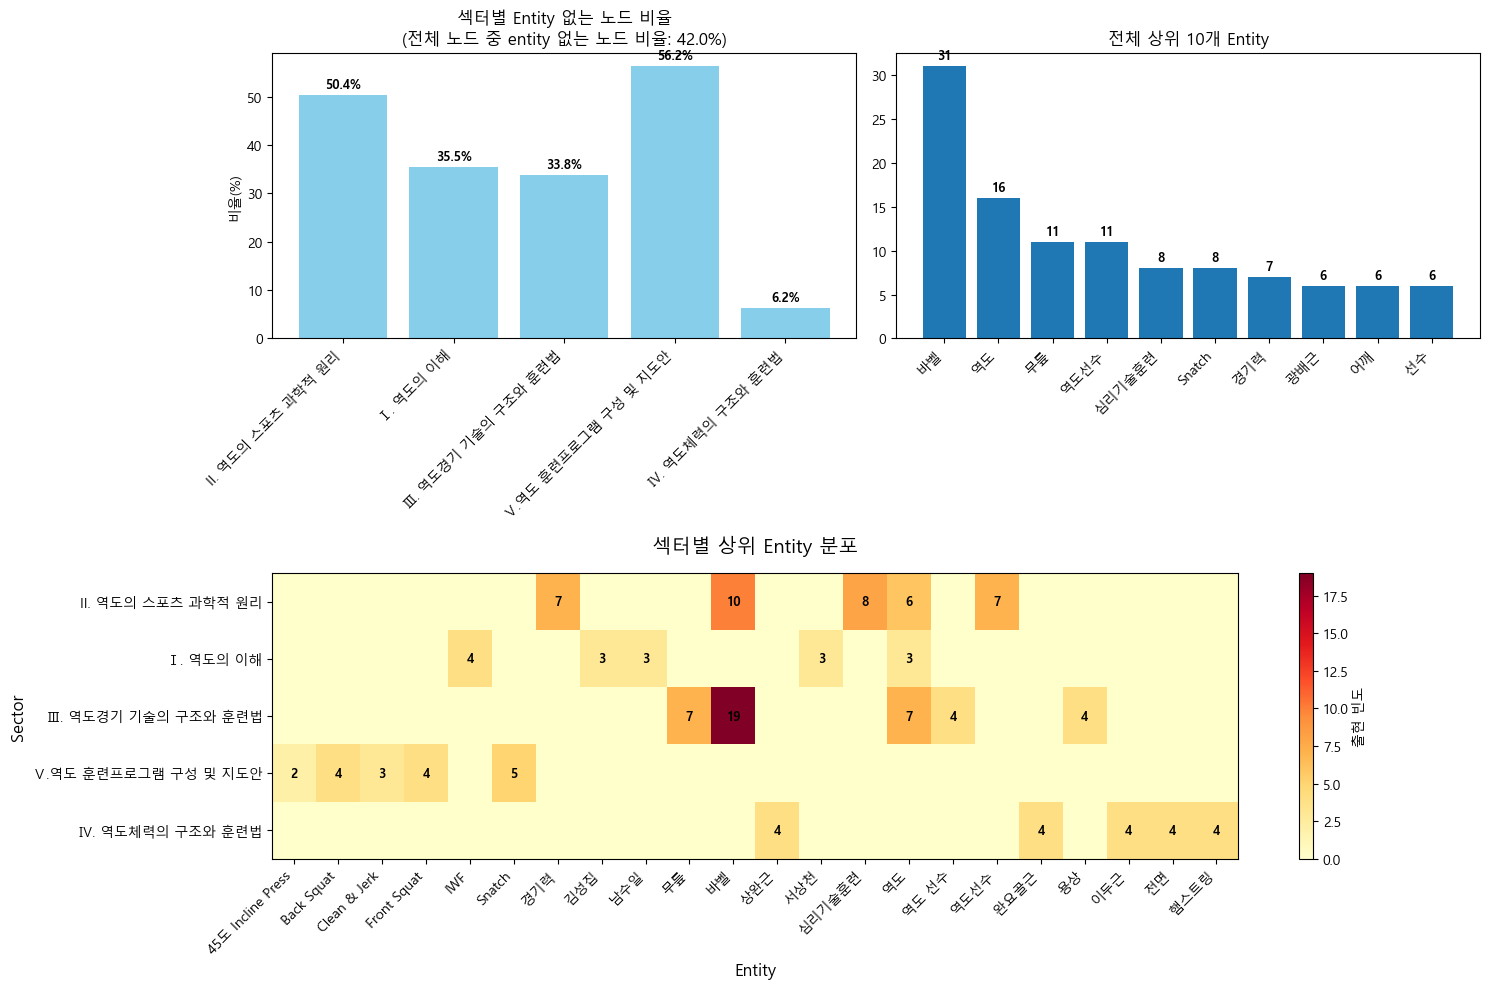

전체 노드 수: 255
Entity가 없는 노드 수: 107
전체 노드 중 entity가 없는 노드 비율: 42.0%


In [9]:
analyzed_result = analyze_node_entity(kg)

### 2-2. knowledge graph의 relationships 분석
* defualt_transforms의 relationship 형성 과정
  * OverlapScoreBuilder relationship
    * 모든 노드의 entities를 집계 후, 상위 5% entities를 noisy로 활용하여 관계 설정 과정에서 배제
    * 두 노드의 공통된 entity 정도에 따라 relationship 형성 유무 결정    
  * Cosine_Similarity relationship
    * 두 노드의 summary embedding의 cosine similarity에 따라 relationship 형성 유무 결정
* default_transforms의 결과, 타 section 과의 relationship 정도 분석
  * Cosine_Similarity relationship의 타 섹션 관계 비율은 66.6%
  * Overlap relationship의 경우 타 섹션 비율은 37.2%
* 시사점
  * Cosine_Similarity relationship은 타 섹션과의 비율도 높고, 섹터간 적정 network density를 가짐
  * overlap relationship은 운동과 관련된 entity 추출이 아닌 범용적인 name entity 추출 기반 relation 형성 과정
  * 그로 인해 overlap relationship의 수 자체도 매우 적으며, 섹터간 network density와 타 섹션간 비율도 낮음

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from typing import List, Dict, Any

def analyze_relationship(
    kg: Any,
    rel_types: List[str] = None,
    figsize: tuple = (7, 5),
    colors: List[str] = ['#4F81BD', '#C0504D'],
    show_plot: bool = True
) -> Dict[str, Dict[str, int]]:
    """
    지식 그래프의 관계를 분석하고 시각화합니다.

    Args:
        kg: 지식 그래프 객체
        rel_types: 분석할 관계 타입 리스트
        figsize: 그래프 크기
        colors: 막대 그래프 색상
        show_plot: 그래프 표시 여부

    Returns:
        Dict[str, Dict[str, int]]: 관계 통계 정보
    """
    # 기본 관계 타입 설정
    if rel_types is None:
        rel_types = ['entities_overlap', 'cosine_similarity']

    # 노드 id → 섹션명 매핑
    node_sector = {}
    for node in kg.nodes:
        try:
            node_id = node.id.hex
            sector = node.properties['document_metadata']['heading']['heading1']
            node_sector[node_id] = sector
        except (AttributeError, KeyError) as e:
            print(f"Warning: Node {node_id} has invalid structure: {e}")
            continue

    # 통계 변수 초기화
    stats = {rtype: {'total': 0, 'same_sector': 0, 'diff_sector': 0} for rtype in rel_types}
    sector_rel_count = defaultdict(int)

    # 관계 순회하며 통계 집계
    for rel in kg.relationships:
        try:
            rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
            source_id = rel.__dict__['source'].id.hex
            target_id = rel.__dict__['target'].id.hex
            source_sector = node_sector.get(source_id, 'Unknown')
            target_sector = node_sector.get(target_id, 'Unknown')

            sector_rel_count[source_sector] += 1
            sector_rel_count[target_sector] += 1

            if rel_type not in stats:
                continue

            stats[rel_type]['total'] += 1
            if source_sector == target_sector:
                stats[rel_type]['same_sector'] += 1
            else:
                stats[rel_type]['diff_sector'] += 1
        except (AttributeError, KeyError) as e:
            print(f"Warning: Invalid relationship structure: {e}")
            continue

    if show_plot:
        for rtype in rel_types:
            plt.figure(figsize=figsize)
            same_count = stats[rtype]['same_sector']
            diff_count = stats[rtype]['diff_sector']
            total = stats[rtype]['total']

            plt.bar(['동일 섹션', '타 섹션'], 
                   [same_count, diff_count], 
                   color=colors)

            for i, v in enumerate([same_count, diff_count]):
                percentage = (v/total*100) if total > 0 else 0
                plt.text(i, v, f'{v} ({percentage:.1f}%)', 
                        ha='center', va='bottom', 
                        fontsize=11, fontweight='bold')

            plt.title(f'{rtype} 관계 분포', fontsize=14)
            plt.ylabel('관계 개수')
            plt.tight_layout()
            plt.show()

    return stats

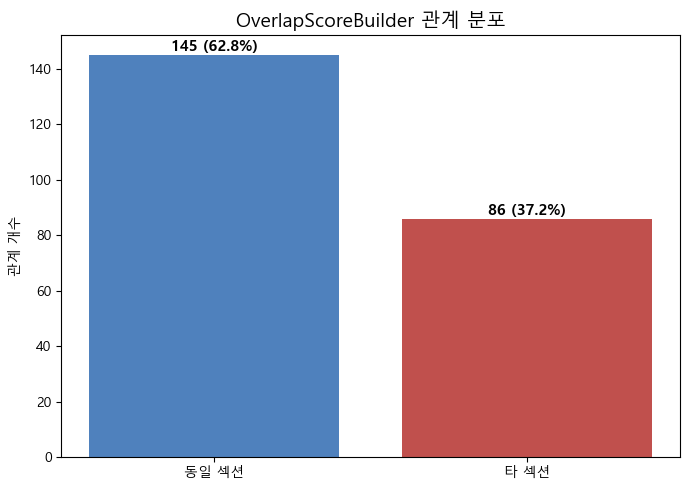

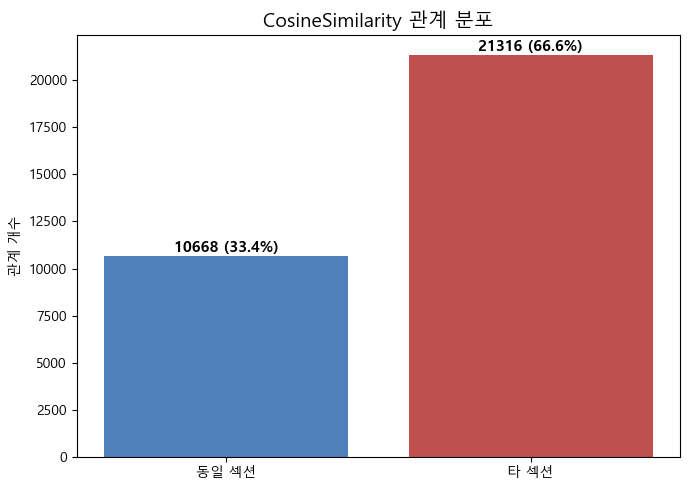

In [11]:
analyze_relationship(kg)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union

def analyze_sector_connection_ratio(
    kg: Any,
    rel_types: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (16, 6),
    color_maps: Optional[Dict[str, str]] = None,
    return_dfs: bool = True,
    show_plot: bool = True
) -> Union[Tuple[pd.DataFrame, ...], None]:
    """
    섹터 간 연결 비율을 분석하고 시각화합니다.

    Args:
        kg: 지식 그래프 객체
        rel_types: 분석할 관계 타입 리스트
        figsize: 그래프 크기
        color_maps: 관계 타입별 컬러맵 딕셔너리
        return_dfs: DataFrame 반환 여부
        show_plot: 그래프 표시 여부

    Returns:
        Optional[Tuple[pd.DataFrame, ...]]: 관계 타입별 연결 비율 DataFrame
    """
    # 기본값 설정
    if rel_types is None:
        rel_types = ['cosine_similarity', 'entities_overlap']
    
    if color_maps is None:
        color_maps = {rtype: 'YlOrRd' for rtype in rel_types}

    # 노드 id → 섹터명 매핑 및 섹터별 노드 id 집합
    node_sector = {}
    sector_nodes = defaultdict(set)
    
    try:
        for node in kg.nodes:
            node_id = node.id.hex
            sector = node.properties['document_metadata']['heading']['heading1']
            node_sector[node_id] = sector
            sector_nodes[sector].add(node_id)
    except (AttributeError, KeyError) as e:
        print(f"Warning: Error processing nodes: {e}")
        return None

    sectors = sorted(sector_nodes.keys())
    n = len(sectors)

    # 관계 타입별 실제 관계 수 매트릭스
    actual_matrices = {rtype: np.zeros((n, n), dtype=int) for rtype in rel_types}
    # 가능한 최대 관계 수 매트릭스
    max_matrix = np.zeros((n, n), dtype=int)

    # 관계 집계
    for rel in kg.relationships:
        try:
            rel_type = getattr(rel, 'type', rel.__dict__.get('type', ''))
            source_id = rel.__dict__['source'].id.hex
            target_id = rel.__dict__['target'].id.hex
            source_sector = node_sector.get(source_id, 'Unknown')
            target_sector = node_sector.get(target_id, 'Unknown')
            
            if source_sector in sectors and target_sector in sectors:
                i = sectors.index(source_sector)
                j = sectors.index(target_sector)
                if rel_type in rel_types:
                    actual_matrices[rel_type][i, j] += 1
        except (AttributeError, KeyError) as e:
            print(f"Warning: Error processing relationship: {e}")
            continue

    # 가능한 최대 관계 수 계산
    for i, s1 in enumerate(sectors):
        for j, s2 in enumerate(sectors):
            max_matrix[i, j] = len(sector_nodes[s1]) * len(sector_nodes[s2])

    # 연결 비율(%) 매트릭스 생성
    ratio_matrices = {}
    ratio_dfs = {}
    
    for rtype in rel_types:
        ratio_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if max_matrix[i, j] > 0:
                    ratio_matrix[i, j] = actual_matrices[rtype][i, j] / max_matrix[i, j] * 100
        ratio_matrices[rtype] = ratio_matrix
        ratio_dfs[rtype] = pd.DataFrame(ratio_matrix, index=sectors, columns=sectors)

    if show_plot:
        # 히트맵 시각화
        fig, axes = plt.subplots(1, len(rel_types), figsize=figsize)
        if len(rel_types) == 1:
            axes = [axes]

        for idx, rtype in enumerate(rel_types):
            im = axes[idx].imshow(
                ratio_matrices[rtype], 
                cmap=color_maps[rtype], 
                vmin=0, 
                vmax=100
            )
            
            plt.colorbar(im, ax=axes[idx], label='연결 비율(%)')
            
            axes[idx].set_xticks(range(n))
            axes[idx].set_xticklabels(sectors, rotation=45, ha='right')
            axes[idx].set_yticks(range(n))
            axes[idx].set_yticklabels(sectors)
            axes[idx].set_title(f'section 간 연결 비율(%) - {rtype}')

            # 값 표시
            for i in range(n):
                for j in range(n):
                    value = ratio_matrices[rtype][i, j]
                    color = 'black' if value < 60 else 'white'
                    axes[idx].text(
                        j, i, f"{value:.1f}%",
                        ha='center', va='center',
                        color=color,
                        fontsize=9,
                        fontweight='bold'
                    )

        plt.tight_layout()
        plt.show()

    if return_dfs:
        return tuple(ratio_dfs[rtype] for rtype in rel_types)
    return None

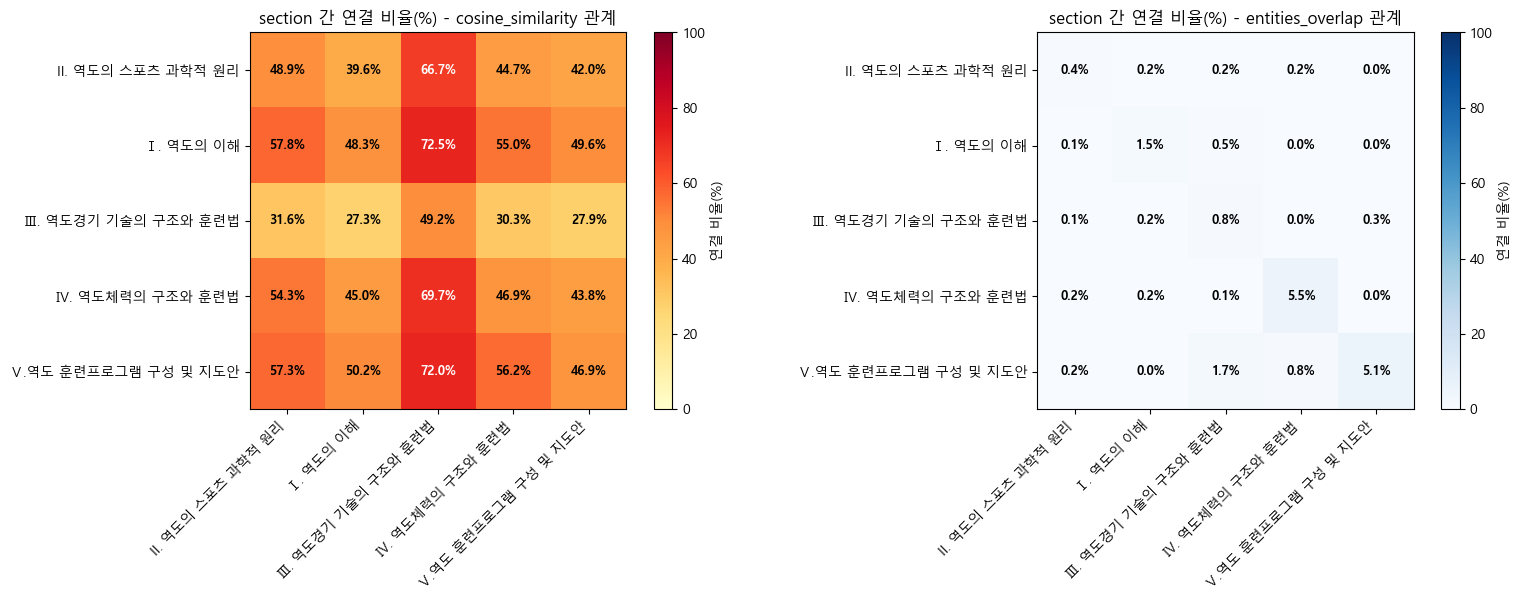

In [13]:
dfs = analyze_sector_connection_ratio(
    kg,
    color_maps=color_maps
)

## 3. MultiHopAbstractQuerySunthesizer 최적화

In [14]:
from typing import Dict, List, Tuple, Union
from dataclasses import dataclass, field

import typing as t
import logging
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
from ragas.testset.graph import KnowledgeGraph, Node

from ragas.testset.synthesizers.multi_hop import MultiHopScenario
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer


logger = logging.getLogger(__name__)

@dataclass
class FastMultiHopAbstractQuerySynthesizer(MultiHopAbstractQuerySynthesizer):
    name: str = "fast_multi_hop_abstract_synthesizer"

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._neighbor_cache = {}
        self._cluster_cache = {}
        
    def _build_neighbor_map(self, knowledge_graph: KnowledgeGraph) -> dict:
        """선처리: 노드별 이웃 노드 맵 생성"""
        if not self._neighbor_cache:
            neighbor_map = defaultdict(set)
            # 한 번의 순회로 모든 관계 처리
            for rel in knowledge_graph.relationships:
                if rel.get_property("summary_similarity"):
                    neighbor_map[rel.source].add(rel.target)
            self._neighbor_cache = dict(neighbor_map)
        return self._neighbor_cache

    def _find_cluster_from_node(self, start_node: Node, neighbor_map: dict, max_depth: int = 2) -> set:
        """단일 노드에서 시작하는 클러스터 찾기"""
        # 캐시 확인
        cache_key = (start_node.id, max_depth)
        if cache_key in self._cluster_cache:
            return self._cluster_cache[cache_key]

        visited = {start_node}
        current_level = {start_node}
        
        # BFS 사용 (더 효율적인 메모리 사용)
        for depth in range(max_depth):
            next_level = set()
            for node in current_level:
                neighbors = neighbor_map.get(node, set())
                next_level.update(n for n in neighbors if n not in visited)
            visited.update(next_level)
            current_level = next_level
            if not current_level:  # 더 이상 확장할 노드가 없으면 중단
                break

        # 결과 캐싱
        self._cluster_cache[cache_key] = visited
        return visited

    def get_node_clusters(self, knowledge_graph: KnowledgeGraph) -> t.List[t.Set[Node]]:
        """최적화된 클러스터 찾기"""
        # 1. 이웃 노드 맵 구축 (캐시 활용)
        neighbor_map = self._build_neighbor_map(knowledge_graph)
        
        # 2. 병렬 처리를 위한 함수
        def process_node_chunk(nodes):
            return [self._find_cluster_from_node(node, neighbor_map) for node in nodes]

        # 3. 노드를 청크로 분할하여 병렬 처리
        chunk_size = max(1, len(knowledge_graph.nodes) // (4 * 2))  # CPU 코어 수의 2배 정도의 청크
        node_chunks = [
            list(knowledge_graph.nodes)[i:i + chunk_size]
            for i in range(0, len(knowledge_graph.nodes), chunk_size)
        ]

        # 4. 병렬 처리 실행
        all_clusters = []
        with ThreadPoolExecutor(max_workers=4) as executor:
            chunk_results = list(executor.map(process_node_chunk, node_chunks))
            for chunk_result in chunk_results:
                all_clusters.extend(chunk_result)

        # 5. 중복 제거 및 최소 크기 필터링 (set 연산 사용)
        unique_clusters = set()
        min_cluster_size = 2  # 최소 클러스터 크기 설정
        
        for cluster in all_clusters:
            if len(cluster) >= min_cluster_size:
                frozen_cluster = frozenset(cluster)
                unique_clusters.add(frozen_cluster)

        logger.info(f"Found {len(unique_clusters)} unique clusters")
        return [set(cluster) for cluster in unique_clusters]

## 4. presona 분석
* 생성 페르소나 결과(8개)
  * 스포츠 심리학자: 선수들의 개별적인 니즈와 팀 역학에 맞춘 심리적 기술을 개발하여 효과적인 훈련과 지원을 보장합니다.
  * 스포츠 생리학자: 스포츠에서 근육 활용과 경기력 향상에 중점을 두고 운동 기술을 분석하고 최적화합니다.
  * 한국 스포츠 역사가: 역도 역사와 국가적 자부심에 미친 영향에 초점을 맞춰 한국 선수들의 국제 대회 성과를 연구하고 기록합니다.
  * 근력 트레이닝 코치: 선수들의 역도 기술과 근육 활용을 최적화하는 데 특화되어 있습니다.
  * 스포츠 심리학자: 선수들의 개별적인 특성과 팀 역학을 고려한 맞춤형 심리적 기술 훈련을 통해 경기력 향상을 위해 선수와 협력합니다.
  * 근력 트레이닝 코치: 선수들에게 적절한 리프팅 기술과 근육 활용법을 교육하여 경기력 향상을 도모합니다.
  * 스포츠 심리학자: 선수들의 개별적인 특성과 팀 역학을 고려하여 정신적 기술과 경기력을 향상시킵니다.
  * 스포츠 심리학자: 선수들의 개별적인 니즈와 팀 역학에 맞춘 심리적 기술 훈련을 통해 경기력을 향상시킵니다.
* 시사점
  * generate_personas_from_kg 설명
    * 문서의 summary_embedding 값을 활용하여 cosine_similarities 기반 클러스터링을 생성
    * cosine_similarities가 0.75 이상인 요약을 하나의 요약으로 생성
    * 각 그룹에서 가장 긴 요약을 대표 요약으로 선정
    * 대표 요약을 기반으로 해당 콘텐트와 상호작용하거나 혜택을 받을 가능성이 있는 단일 페르소나를 생성
  * generate_persona_from_kg 결과가 실제 예상 사용자와 큰 차이를 보임

In [15]:
from ragas.testset.persona import generate_personas_from_kg

personas = generate_personas_from_kg(kg=kg, llm=generator_llm, num_personas=8)

Generating personas: 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


### default_distribution 기반의 합성 데이터셋 생성

In [16]:
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.specific import MultiHopSpecificQuerySynthesizer
from ragas.testset.synthesizers.multi_hop.abstract import MultiHopAbstractQuerySynthesizer


query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.3),
    (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.3),
    (FastMultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.4)
]


generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
    knowledge_graph=kg,
    persona_list=personas,
)

testset = generator.generate(testset_size=50, query_distribution=query_distribution)
test_df = testset.to_pandas()

Generating Samples: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


## 5. 번역

In [17]:
import re
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def classify_language(text):
    english_count = len(re.findall(r'[a-zA-Z]', text))
    korean_count = len(re.findall(r'[가-힣]', text))

    if english_count >= korean_count:
        return 'english'

    return 'korean'


def translate(testset_df):
    template = """
        You are an expert translator specializing in English to Korean translation.

        Translate the following English text into natural Korean.  
        Only output the translated Korean text.  
        If a term is a proper noun or a commonly used English term (e.g., "clean and jerk"), transliterate it into Korean and include the original English in parentheses.

        Text:  
        {input_text}
    """ 

    llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
    prompt = PromptTemplate.from_template(template)
    chain = prompt | llm | StrOutputParser()

    testset_df['language_user_input'] = testset_df['user_input'].apply(lambda x : classify_language(x))
    testset_df['language_reference'] = testset_df['reference'].apply(lambda x : classify_language(x))

    user_data = testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'].tolist()
    reference_data = testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'].tolist()

    translate_user = chain.batch(user_data, config={'max_concurrency': 5})
    translate_reference = chain.batch(reference_data, config={'max_concurrency': 5})

    testset_df.loc[(testset_df['language_user_input'] == 'english'), 'user_input'] = translate_user
    testset_df.loc[(testset_df['language_reference'] == 'english'), 'reference'] = translate_reference

    return testset_df.iloc[:, :4]

In [ ]:
import re 

def make_chunk_dict(knowledge_graph):
    chunk_dict = {}
    chunk_id_dict = {}
    chunk_summary_embedding = {}
    for node in knowledge_graph.nodes:
        section = node.properties['document_metadata']['heading']['heading1']
        chunk_id = node.properties['document_metadata']['chunk_id']
        summary_embedding = node.properties['summary_embedding']
        page_content = node.properties['page_content']

        chunk_dict[page_content] = section
        chunk_id_dict[page_content] = chunk_id
        chunk_summary_embedding[page_content] = summary_embedding
    return chunk_dict, chunk_id_dict, chunk_summary_embedding

def regular_expression(reference_contexts, chunk_dict):
    if len(reference_contexts) == 1:
        return [chunk_dict[reference_contexts[0]]]
    else:
        return [chunk_dict[re.sub(r"<\d+-hop>\n\n", "", text)] for text in reference_contexts] 
    
    
def analyze_synthetic_data(kg, testset_df):
    chunk_dict, chunk_id_dict, chunk_summary_embedding = make_chunk_dict(kg)
    testset_df['reference_contexts_section'] = testset_df['reference_contexts'].apply(lambda x : regular_expression(x, chunk_dict))
    testset_df = testset_df.drop(columns = ['language_user_input', 'language_reference'])

    return testset_df

result = analyze_synthetic_data(kg, test_df)

In [18]:
trans_df = translate(test_df)
# trans_df.to_csv('../data/document/역도/generated_persona_dataset.csv', index=False)

In [33]:
result.head(2)

,user_input,reference_contexts,reference,synthesizer_name,reference_contexts_section
0,역도 대회에서 엄지(thumb) 사용에 관한 규정은 무엇인가요?,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...",역도 대회에서 붕대(bandage) 혹은 석고(cast)는 손가락(finger) 혹...,single_hop_specifc_query_synthesizer,[Ⅰ. 역도의 이해]
1,바벨의 무게를 들어올리기 위해 필요한 회전력은 얼마인가요?,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...",바벨이 150kg이고 바벨의 수직축과 엉덩이 관절까지의 거리가 60cm라면 바벨을 ...,single_hop_specifc_query_synthesizer,[II. 역도의 스포츠 과학적 원리]
